In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

import os
print(os.listdir("../input"))

['FE_hourly.csv', 'NI_hourly.csv', 'DOM_hourly.csv', 'est_hourly.paruqet', 'PJMW_hourly.csv', 'COMED_hourly.csv', 'EKPC_hourly.csv', 'PJME_hourly.csv', 'DEOK_hourly.csv', 'DAYTON_hourly.csv', 'DUQ_hourly.csv', 'PJM_Load_hourly.csv', 'pjm_hourly_est.csv', 'AEP_hourly.csv']


***For the initial data analysis, some lines of data are copied from PJME_hourly.csv ***
* Datetime,PJME_MW
* 2002-12-31 01:00:00,26498.0
* 2002-12-31 02:00:00,25147.0
* 2002-12-31 03:00:00,24574.0
* 2002-12-31 04:00:00,24393.0
* 2002-12-31 05:00:00,24860.0
* 2002-12-31 06:00:00,26222.0

From this data sample, we can understand about the data and its format.

In [2]:
# As per the inital analysis, data read from PJME_hourly.csv. 
#   timestamp column set as index column
#   and speccifying date parsing in column 0.
#   default delimeter used
data = pd.read_csv('../input/PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [3]:
# Verifying the loaded data
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


### Data Cleaning
* Check the data types
* Check the missing data
    * If the data is missing, fix it

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
PJME_MW    145366 non-null float64
dtypes: float64(1)
memory usage: 2.2 MB


In [5]:
data.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [6]:
# to get the null value of PJME_MW column
data['PJME_MW'].isnull().sum()

0

No missing data found. And statistically data is good.

Text(0, 0.5, 'MW')

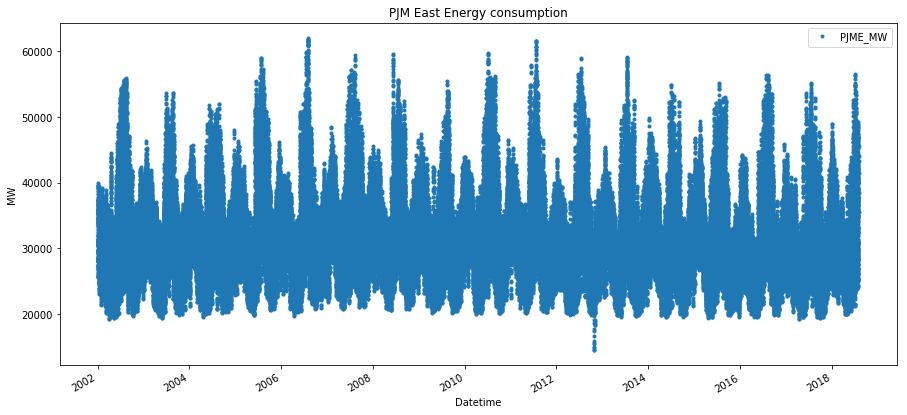

In [7]:
_ = data.plot( style='.', figsize=( 15, 7 ), title='PJM East Energy consumption' )
plt.ylabel ( 'MW' )

In [8]:
# looks like MW field is integer, not float
data['PJME_MW'] = data['PJME_MW'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
PJME_MW    145366 non-null int64
dtypes: int64(1)
memory usage: 2.2 MB


As per the graph from 2012 -2014, we can see a dip in energy consumption. Need to analyse the reason behind that.

In [9]:
data['date'] = data.index
data_2012 = data.loc[np.logical_and( np.logical_and( data['date'].dt.year == 2012 , data['date'].dt.month == 10), data['date'].dt.day > 20  )]
data_2012.info()
data_2012.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2012-10-31 01:00:00 to 2012-10-21 00:00:00
Data columns (total 2 columns):
PJME_MW    264 non-null int64
date       264 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.2 KB


,PJME_MW,date
Datetime,,
2012-10-31 01:00:00,19155,2012-10-31 01:00:00
2012-10-31 02:00:00,18618,2012-10-31 02:00:00
2012-10-31 03:00:00,18350,2012-10-31 03:00:00
2012-10-31 04:00:00,18330,2012-10-31 04:00:00
2012-10-31 05:00:00,18880,2012-10-31 05:00:00


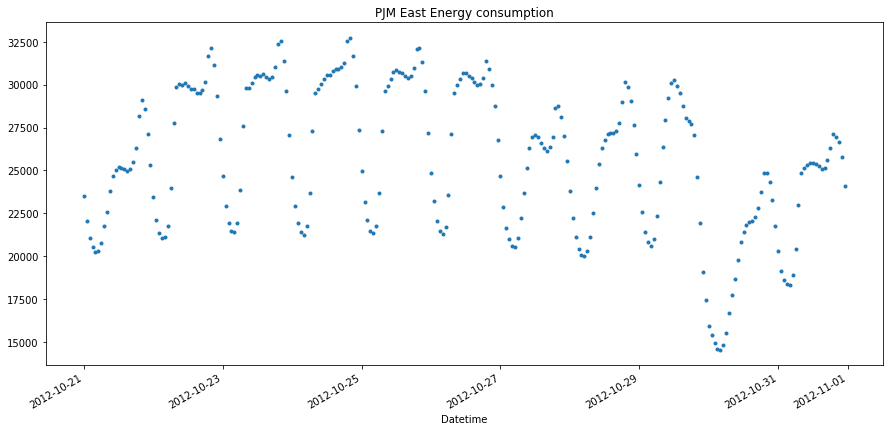

In [10]:
_ = data_2012['PJME_MW'].plot( style='.', figsize=( 15, 7 ), title='PJM East Energy consumption' )

In [11]:
data_2012.tail( 30)

,PJME_MW,date
Datetime,,
2012-10-22 20:00:00,32147,2012-10-22 20:00:00
2012-10-22 21:00:00,31163,2012-10-22 21:00:00
2012-10-22 22:00:00,29312,2012-10-22 22:00:00
2012-10-22 23:00:00,26854,2012-10-22 23:00:00
2012-10-23 00:00:00,24665,2012-10-23 00:00:00
2012-10-21 01:00:00,22050,2012-10-21 01:00:00
2012-10-21 02:00:00,21073,2012-10-21 02:00:00
2012-10-21 03:00:00,20511,2012-10-21 03:00:00
2012-10-21 04:00:00,20225,2012-10-21 04:00:00


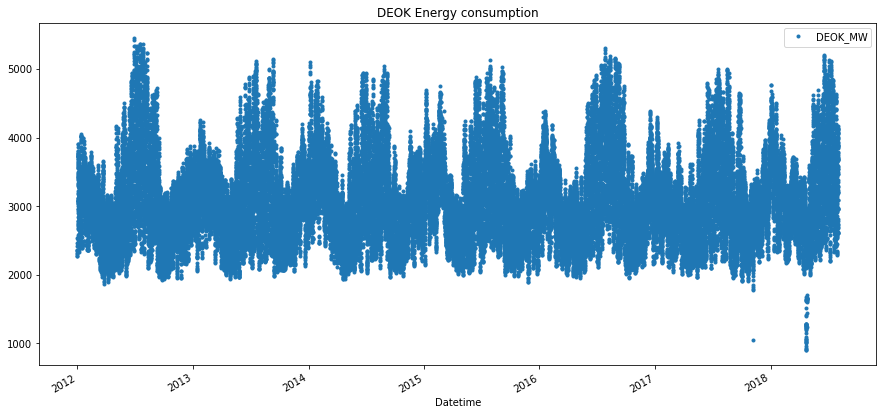

In [12]:
# will check the same type of issue is there in other data or not.
data_deok = pd.read_csv('../input/DEOK_hourly.csv', index_col=[0], parse_dates=[0])
_ = data_deok.plot( style='.', figsize=( 15, 7 ), title='DEOK Energy consumption' )

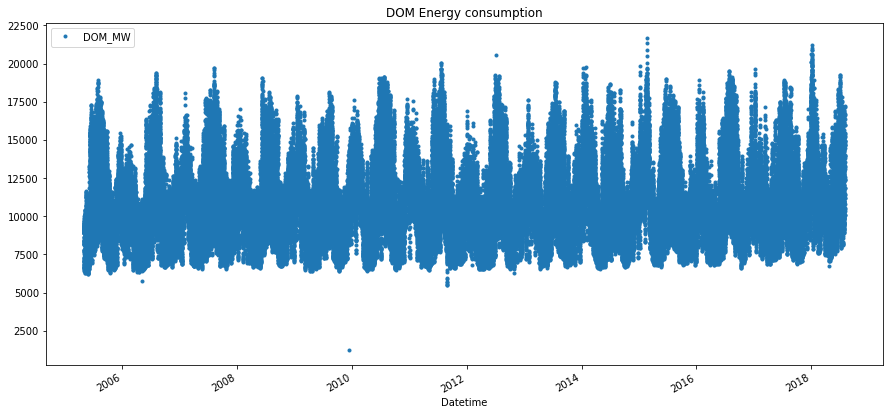

In [13]:
# DOM_hourly
data_dom = pd.read_csv('../input/DOM_hourly.csv', index_col=[0], parse_dates=[0])
_ = data_dom.plot( style='.', figsize=( 15, 7 ), title='DOM Energy consumption' )

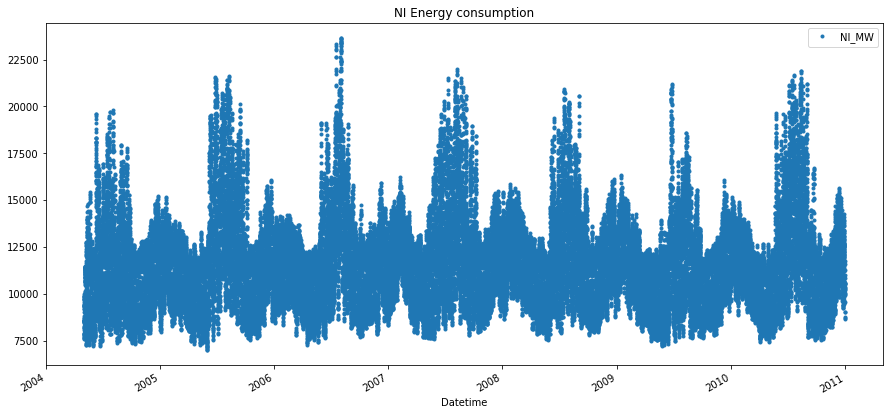

In [14]:
# NI_hourly
data_ni = pd.read_csv('../input/NI_hourly.csv', index_col=[0], parse_dates=[0])
_ = data_ni.plot( style='.', figsize=( 15, 7 ), title='NI Energy consumption' )

> > **Analysis details of energey consumption *dip on 2012-10-30* in PJME data**
* As per the graph and data analysis, the data is real. No missing data found
* As per the date, I didn't find any specific reason for this dip 
* In other regions data also, similar dip is there. But its not consistent. 
    * Might be this data is an aggregation of some sub regions. If any sub region data is missing, these type of scenario can occur.

**Feature Analysis**

In [15]:
data.head(20)

,PJME_MW,date
Datetime,,
2002-12-31 01:00:00,26498,2002-12-31 01:00:00
2002-12-31 02:00:00,25147,2002-12-31 02:00:00
2002-12-31 03:00:00,24574,2002-12-31 03:00:00
2002-12-31 04:00:00,24393,2002-12-31 04:00:00
2002-12-31 05:00:00,24860,2002-12-31 05:00:00
2002-12-31 06:00:00,26222,2002-12-31 06:00:00
2002-12-31 07:00:00,28702,2002-12-31 07:00:00
2002-12-31 08:00:00,30698,2002-12-31 08:00:00
2002-12-31 09:00:00,31800,2002-12-31 09:00:00


From the Timestamp, we can create lot of new features( year, month, hour, day of month, day of week .. ) for the better prediction.

In [16]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['dayofmonth'] = data['date'].dt.day
data['quarter'] = data['date'].dt.quarter
data['dayofyear'] = data['date'].dt.dayofyear
data['weekofyear'] = data['date'].dt.weekofyear
data['dayofweek'] = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 10 columns):
PJME_MW       145366 non-null int64
date          145366 non-null datetime64[ns]
year          145366 non-null int64
month         145366 non-null int64
dayofmonth    145366 non-null int64
quarter       145366 non-null int64
dayofyear     145366 non-null int64
weekofyear    145366 non-null int64
dayofweek     145366 non-null int64
hour          145366 non-null int64
dtypes: datetime64[ns](1), int64(9)
memory usage: 12.2 MB


In [18]:
data = data.sort_index()
data.head()

,PJME_MW,date,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393,2002-01-01 01:00:00,2002,1,1,1,1,1,1,1
2002-01-01 02:00:00,29265,2002-01-01 02:00:00,2002,1,1,1,1,1,1,2
2002-01-01 03:00:00,28357,2002-01-01 03:00:00,2002,1,1,1,1,1,1,3
2002-01-01 04:00:00,27899,2002-01-01 04:00:00,2002,1,1,1,1,1,1,4
2002-01-01 05:00:00,28057,2002-01-01 05:00:00,2002,1,1,1,1,1,1,5


In [19]:
# the date column is parsed to multiple features. So that column is not required
data.drop( columns = 'date', inplace = True )

I tried to add holidays also to the feature list. But its not giving any improvement in the model. So I commented it.

In [20]:
# from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# from datetime import timedelta
# one_day = timedelta(days=1)
# cal = calendar()
# data['is_holiday'] = data.index.isin([d.date() for d in cal.holidays()])
# data['is_prev_holiday'] = data.index.isin([( d.date() + one_day ) for d in cal.holidays()])
# data['is_next_holiday'] = data.index.isin([( d.date() - one_day ) for d in cal.holidays()])
# data['is_holiday'] = data['is_holiday'].astype('category')
# data['is_prev_holiday'] = data['is_prev_holiday'].astype('category')
# data['is_next_holiday'] = data['is_next_holiday'].astype('category')


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 9 columns):
PJME_MW       145366 non-null int64
year          145366 non-null int64
month         145366 non-null int64
dayofmonth    145366 non-null int64
quarter       145366 non-null int64
dayofyear     145366 non-null int64
weekofyear    145366 non-null int64
dayofweek     145366 non-null int64
hour          145366 non-null int64
dtypes: int64(9)
memory usage: 11.1 MB


All the above independent variables are like category type. But no benfit to the model. So this also commented.

In [22]:
# New Category variables created
#data = pd.get_dummies( data,
#                       columns=[ 'year','month','dayofmonth','quarter','dayofyear', 'weekofyear', 'dayofweek','hour'])

In [23]:
# New Category variables created
# data = pd.get_dummies( data,
#                        columns=[ 'is_holiday','is_prev_holiday', 'is_next_holiday'])

**Data Splitting**

In [24]:
def split_data( data, split_date ):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

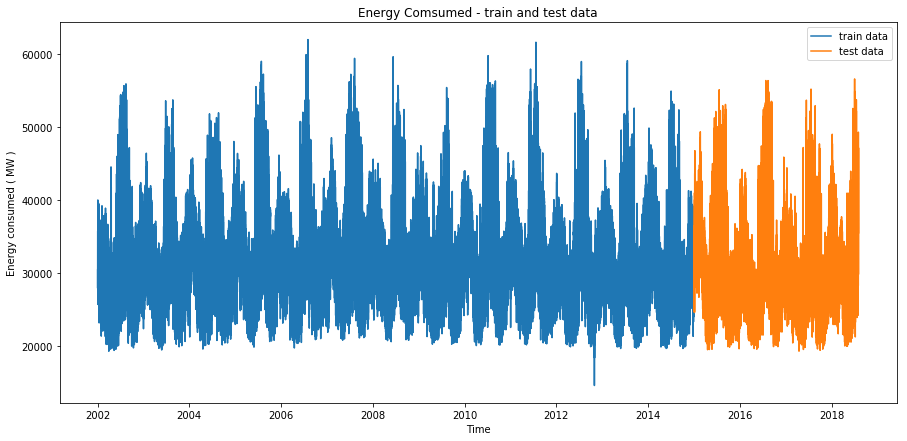

In [25]:
train, test = split_data( data, '01-Jan-2015')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Time')
plt.ylabel('Energy consumed ( MW )')
plt.plot(train.index,train['PJME_MW'], label='train data' )
plt.plot(test.index,test['PJME_MW'], label='test data')
plt.title( 'Energy Comsumed - train and test data' )
plt.legend()
plt.show()

In [26]:
X_train = train
y_train = train['PJME_MW']
X_test = test
y_test = test['PJME_MW']
X_train.drop( columns = 'PJME_MW', inplace = True )
X_test.drop( columns = 'PJME_MW', inplace = True )


**Applying XGBoost Model**

In [27]:
model = xgb.XGBRegressor(  n_estimators = 250,
                           max_depth= 5,
                           learning_rate= 0.069,
                           subsample=1,
                           colsample_bytree=1)

**For fine-tune the model, the hyper parameters are tried with reasonable values.**
* Based on the MSE, the best suitable parmeters are set.
*     Hyper parmeter tried values are given below
    * max_depth = 3,5,6,8
    * learning_rate = 0.01, 0.02, 0.05, 0.08, 0.07, 0.069, 0.065, 0.071,0.69
    * subsample = 0.8, 0.9, 0.95, 1



In [28]:
model.fit( X_train, y_train,
           eval_set=[ ( X_train, y_train ), ( X_test, y_test )],
           early_stopping_rounds = 100, # stop if 50 consequent rounds without decrease of error
           verbose = True ) # Change verbose to True if you want to see it train

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:30686.7	validation_1-rmse:29739.3
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:28603	validation_1-rmse:27653.6
[2]	validation_0-rmse:26665	validation_1-rmse:25717.3
[3]	validation_0-rmse:24862.5	validation_1-rmse:23916.6
[4]	validation_0-rmse:23186.5	validation_1-rmse:22243
[5]	validation_0-rmse:21629.1	validation_1-rmse:20692.2
[6]	validation_0-rmse:20179.5	validation_1-rmse:19246
[7]	validation_0-rmse:18832.5	validation_1-rmse:17904.3
[8]	validation_0-rmse:17581.5	validation_1-rmse:16661.4
[9]	validation_0-rmse:16420	validation_1-rmse:15506.6
[10]	validation_0-rmse:15341.4	validation_1-rmse:14442.2
[11]	validation_0-rmse:14341.5	validation_1-rmse:13451
[12]	validation_0-rmse:13412.4	validation_1-rmse:12527.6
[13]	validation_0-rmse:12551.5	validation_1-rmse:11681.2
[14]	validation_0-rmse:11749.8	validation_1-rmse:10894.2
[15]	va

[142]	validation_0-rmse:2576.71	validation_1-rmse:3822.5
[143]	validation_0-rmse:2567.88	validation_1-rmse:3826.17
[144]	validation_0-rmse:2566.76	validation_1-rmse:3825.93
[145]	validation_0-rmse:2565.71	validation_1-rmse:3827.03
[146]	validation_0-rmse:2565.03	validation_1-rmse:3827.64
[147]	validation_0-rmse:2564.42	validation_1-rmse:3828.31
[148]	validation_0-rmse:2559.72	validation_1-rmse:3831.3
[149]	validation_0-rmse:2551.9	validation_1-rmse:3836.46
[150]	validation_0-rmse:2544.77	validation_1-rmse:3837.65
[151]	validation_0-rmse:2543.7	validation_1-rmse:3837.48
[152]	validation_0-rmse:2540.36	validation_1-rmse:3837.62
[153]	validation_0-rmse:2533.63	validation_1-rmse:3839.87
Stopping. Best iteration:
[53]	validation_0-rmse:3082.81	validation_1-rmse:3656.52



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.069, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

**Predicting using test data**

In [29]:
X_test_pred = model.predict(X_test)
pd.DataFrame(X_test_pred).head()

,0
0,30540.365234
1,30285.992188
2,30110.375000
3,30110.375000
4,30110.375000


**Measure the Mean Square Error**

In [30]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

13370220.45298137

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
mean_absolute_percentage_error(y_test,X_test_pred)

8.524443189541369

**Feature importance**

In [33]:
def plot_performance(base_data, test_data, test_pred, date_from, date_to, title=None):
    plt.figure(figsize=(15,6))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title( title )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Energy consumed ( MW )' )
    plt.plot( base_data.index,base_data['PJME_MW'], label='data' )
    plt.plot( test_data.index, test_pred, label='prediction' )
    plt.xlim( left=date_from, right=date_to )
    plt.legend()

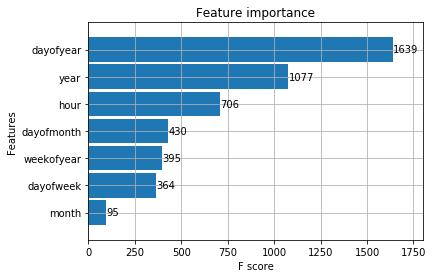

In [34]:
xgb.plot_importance( model, height = 0.9, max_num_features= 10 )


****Plot the predicitions****

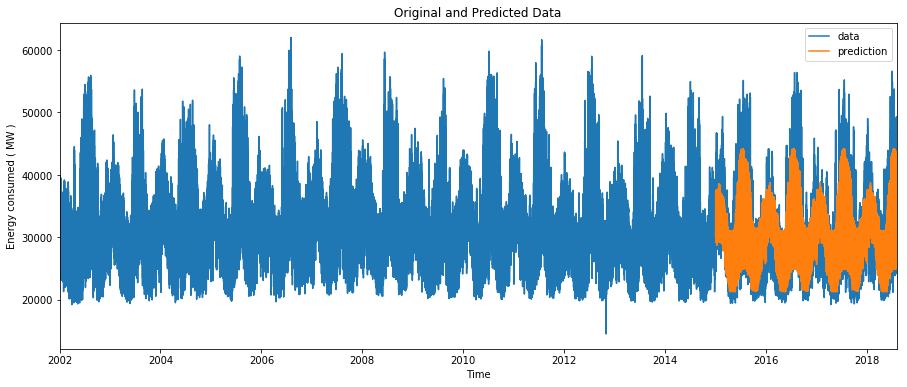

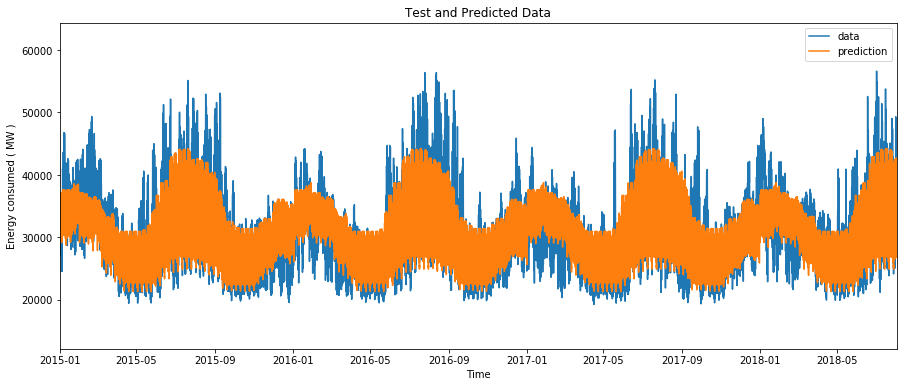

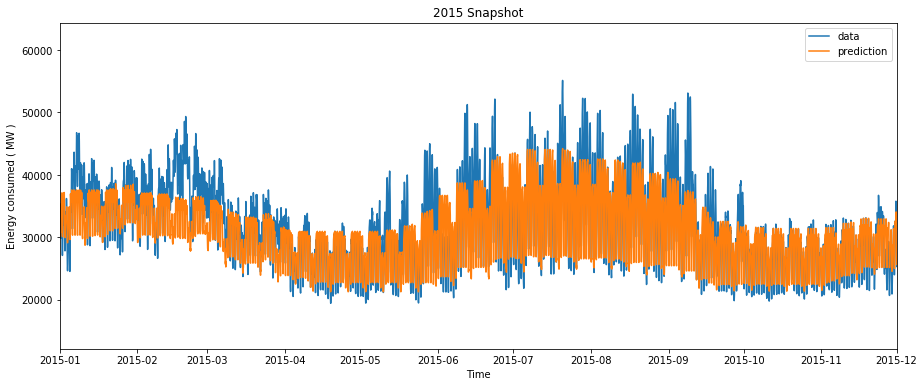

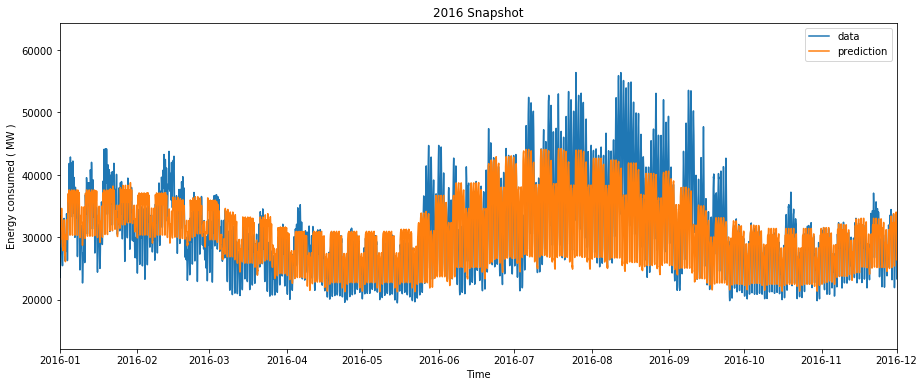

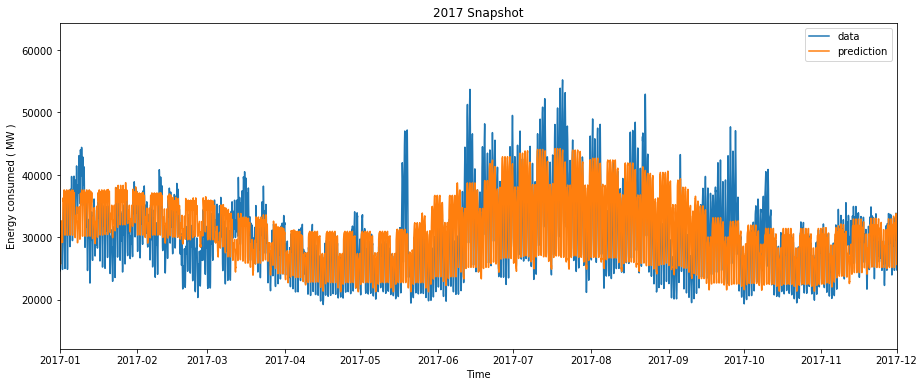

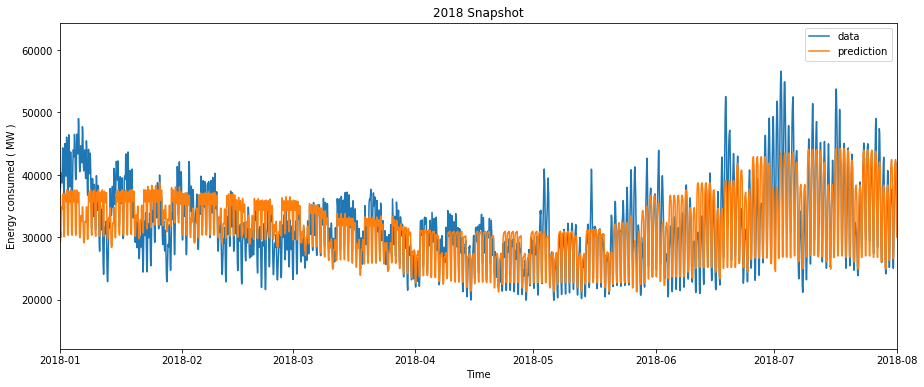

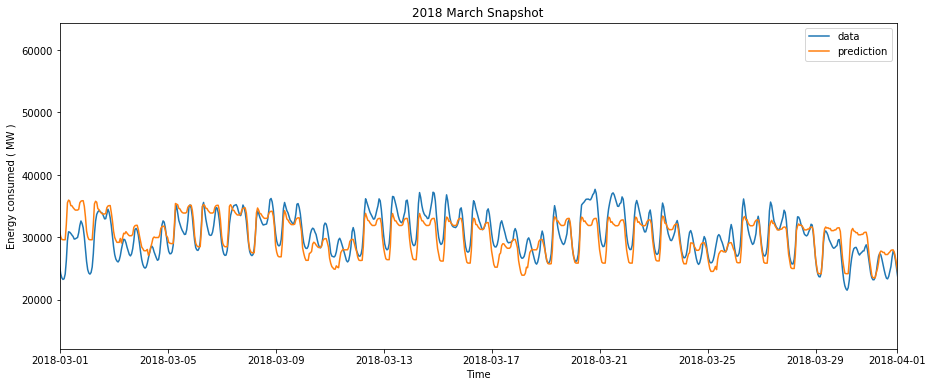

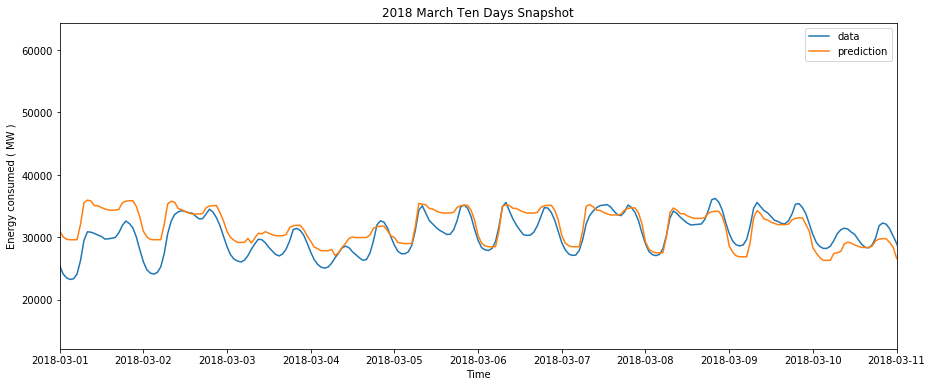

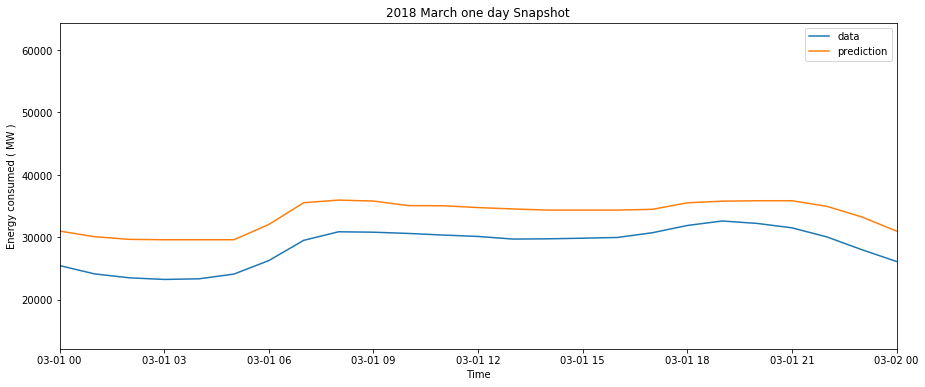

In [39]:
plot_performance(data, X_test, X_test_pred, data.index[0].date(), data.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(data, X_test, X_test_pred, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

plot_performance(data, X_test, X_test_pred, '01-01-2015', '12-01-2015', '2015 Snapshot')
plot_performance(data, X_test, X_test_pred, '01-01-2016', '12-01-2016', '2016 Snapshot')
plot_performance(data, X_test, X_test_pred, '01-01-2017', '12-01-2017', '2017 Snapshot')
plot_performance(data, X_test, X_test_pred, '01-01-2018', '08-01-2018', '2018 Snapshot')

plot_performance(data, X_test, X_test_pred, '03-01-2018', '04-01-2018', '2018 March Snapshot')
plot_performance(data, X_test, X_test_pred, '03-01-2018', '03-11-2018', '2018 March Ten Days Snapshot')
plot_performance(data, X_test, X_test_pred, '03-01-2018', '03-02-2018', '2018 March one day Snapshot')

plt.show()